In [1]:
"""Test module for explanation ai implemented with LIME"""
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from keras.models import load_model
from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

WORK_DIR = ".."
NOTEBOOK_DIR = "."
DATA_DIR = f"{NOTEBOOK_DIR}/data"
assert os.path.exists(DATA_DIR), f"Not found folder {DATA_DIR}"
assert os.path.exists(WORK_DIR), f"Not found folder {WORK_DIR}"
assert os.path.exists(NOTEBOOK_DIR), f"Not found folder {NOTEBOOK_DIR}"

Using TensorFlow backend.


## Prepare Data Set

In [3]:
def preload_uts(data_dir=DATA_DIR):
    df = pd.read_csv(f"{data_dir}/climate_small.csv")
    with open(f"{data_dir}/climate_small_schema.json") as f:
        schema = json.load(f)
        df = df.astype(schema)

    df = df.set_index("measure_date")
    tmk = df.query("stations_id == 2074")["tmk"]

    input_steps = 32
    return tmk[-input_steps:].to_numpy()

In [4]:
model = load_model(f"{DATA_DIR}/uts_tmk_32_1.h5")
def predict_fn(x, *args):
    x = x.reshape(1, -1, 1)

    y_hat = model.predict(x, *args)

    # flatten to one value, this depends on the model
    return y_hat.ravel().item()

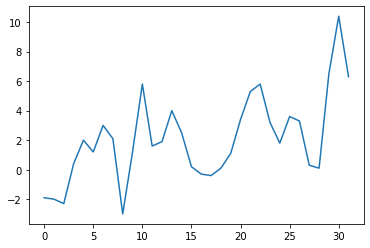

In [5]:
import matplotlib.pyplot as plt

ts_original = preload_uts()
plt.plot(ts_original)

## Fitting the explaining model by using LIME Time Series

In [45]:
# Convert ts x to a (n_features, n_samples)
ts_lime = LIMETimeSeries(window_size=4, sample_size=100)
ts_lime.explain(ts_original.reshape(1, -1), predict_fn=predict_fn)

In [42]:
z_prime, z, z_hat, sample_weight = ts_lime.get_a_local_sample()
print("z': \t", z_prime)
print("z: \t", z)
print("z_hat: \t", z_hat)
print("pi: \t", sample_weight)


z': 	 [[0 0 0 0 1 1 0 0]]
z: 	 [[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  -0.3 -0.4  0.1  1.1  3.4  5.3  5.8  3.2  0.   0.   0.   0.
   0.   0.   0.   0. ]]
z_hat: 	 1.2809514999389648
pi: 	 0.5709036849436039


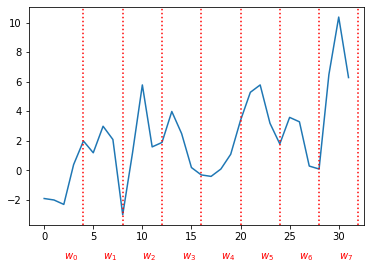

In [8]:
plt.plot(ts_original)
window_size = ts_lime.window_size
for i in range(ts_lime.n_segments):
    p_x = window_size * (i + 1)
    plt.axvline(x=p_x, c='r', ls=':')

    text_x = p_x - (window_size / 2) # center
    text_y = min(ts_original) - 3   # manually
    plt.text(text_x, text_y, r"$w_{%i}$" % i, c='r')


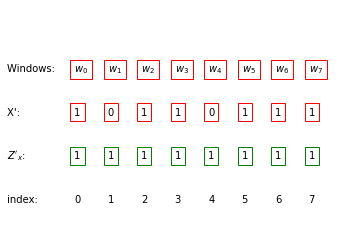

In [9]:
arr = z_prime.ravel()
row_relative = [0.7, 0.5, 0.3, 0.1]

plt.axis('off')
plt.text(0, row_relative[0], r"Windows: ")
plt.text(0, row_relative[1], r"X': ")
plt.text(0, row_relative[2], r"${Z'}_x$: ")
plt.text(0, row_relative[3], 'index:')
for i, c in enumerate(arr):
    p_x = (i + 2) * 0.1
    plt.text(p_x, row_relative[0], r"$w_{%i}$" % i, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(p_x, row_relative[1], c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(p_x, row_relative[2], 1, bbox=dict(facecolor='none', edgecolor='green'))
    plt.text(p_x, row_relative[3], i, )

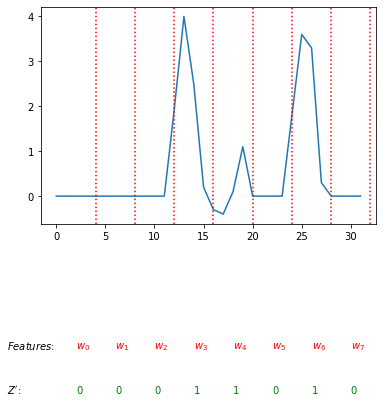

In [43]:
# Todo: plot (z_original + z' + axvline)
z_prime, z_original, z_hat, sample_weight = ts_lime.get_a_local_sample()

# Normalize data from shape (n_features, n_steps) -> uts: (, nsteps)
z_prime = z_prime.ravel()
z_original = z_original.ravel()

# Z
plt.plot(z_original)

# Segments + Z'
w_text_y = min(z_original) - 3   
z_text_y = w_text_y - 1
plt.text(-5, w_text_y, r"$Features$: ")
plt.text(-5, z_text_y, r"$Z'$: ")
window_size = ts_lime.window_size
for i in range(ts_lime.n_segments):
    p_x = window_size * (i + 1)
    plt.axvline(x=p_x, c='r', ls=':')
    text_x = p_x - (window_size / 2) # center
    
    plt.text(text_x, w_text_y, r"$w_{%i}$" % i, c='r')
    plt.text(text_x, z_text_y, z_prime[i], c='g')

In [47]:
# ts_lime = LIMETimeSeries(window_size=4, sample_size=1000)
# ts_lime.explain(ts_original.reshape(1, -1), predict_fn=predict_fn)
ts_lime.coef

array([-0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.51691191])

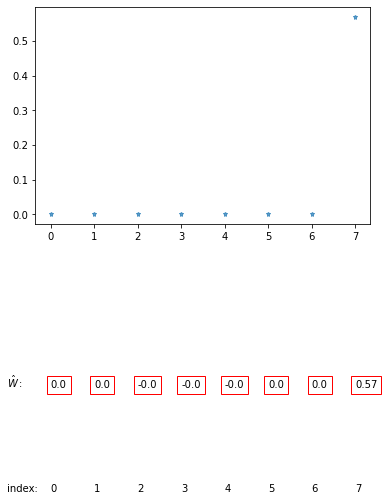

In [12]:
arr = ts_lime.coef.round(2)

w_text_y = min(arr) - 0.5 
z_text_y = w_text_y - 0.3
plt.plot(arr, alpha=0.7, linestyle='none', marker='*', markersize=5)

plt.text(-1, w_text_y, r"$\hatW:$ ")
plt.text(-1, z_text_y, 'index:')
for i, c in enumerate(arr):
    plt.text(i, w_text_y, c, bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(i, z_text_y, i, )

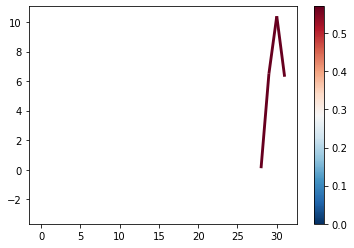

In [18]:
# Plot ts_original with highlighting important points
from matplotlib.collections import LineCollection
import matplotlib.colors as colors

# Weight features -> to weight for each point
weight_features = arr.round(2)
weight_points = np.ones_like(ts_original)
window_size = ts_lime.window_size
for i, w in enumerate(weight_features):
    start = i * window_size
    weight_points[start : start + window_size] = w

# Create coordinates (x, y)
# Line-starts from : 0 -> semi-last (-1)
# Line-ends from : 1 -> final
coords = list(enumerate(ts_original))
line_widths = 5 * abs(weight_points)
# line_widths = (1 + weight_points) ** 2
color_map = plt.cm.get_cmap('RdBu_r')
color_norm = colors.Normalize()

lines = [(start, end) for start, end in zip(coords[:-1], coords[1:])]
lines = LineCollection(lines, linewidths=line_widths, array=weight_points, norm=color_norm, cmap=color_map)
# Alternative with lines.set_array(.), lines.set_widths()

fig, ax = plt.subplots()
# ax.plot(ts_original)  # for test
line = ax.add_collection(lines)
ax.autoscale()
plt.colorbar(line)